In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

#### modules

In [3]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, to_tree, ClusterNode
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
import os
from itertools import accumulate
from sklearn.metrics.pairwise import pairwise_distances, euclidean_distances
from scipy.stats import entropy
from math import floor
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm.auto import tqdm
from pandas.tseries.offsets import MonthEnd
import plotting 
from matplotlib.colors import LogNorm, Normalize
from  matplotlib import colormaps as cmaps 
from scipy.stats import kruskal 
from scikit_posthocs import posthoc_dunn
from scipy import stats 
import json
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
import matplotlib.patches as mpatches
from matplotlib import colors

/home/alberto/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from os import path
with open(path.expanduser("~") + "/sys_specific.json") as file: 
    params = json.load(file)
_HOME_ = params["home"] + "/PHD"
import modify_dataset

In [5]:
def Pielou_evenness(data): 
    if data.size == 1: 
        return 0
    H = entropy(data, base = 10)
    H_max = np.log10(len(data))
    return H / H_max

### Basics variables and parameters

In [6]:
phyto_abundances = pd.read_csv(_HOME_ + "/MSFD/Data/Modulo1/phyto_abund_modified.csv", index_col=0)
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])

In [7]:
with open(_HOME_ + "/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params

In [8]:
phyto_abund_simplified = modify_dataset.make_simplified_dataset(phyto_abundances, 0.7)
phyto_abund_simplified = modify_dataset.add_season_column(phyto_abund_simplified, seasons)
phyto_abund_simplified = modify_dataset.add_coast_dist_column(phyto_abund_simplified)
phyto_abund_simplified["Date"] = pd.to_datetime(phyto_abund_simplified["Date"]) + MonthEnd(0)
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = ordered_regions, ordered = True)

In [9]:
taxonomic_tree = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Phyto_taxonomic_tree.xlsx")
taxonomic_tree.drop_duplicates(inplace=True)
phyto_abund_simplified = phyto_abund_simplified.merge(taxonomic_tree.loc[:,["ScientificName", "Genus", "Class"]], how = "left", left_on="Taxon", right_on="ScientificName")
phyto_abund_simplified["Class"] = phyto_abund_simplified["Class"].astype(str)

In [10]:
phyto_abund_simplified = modify_dataset.add_det_level_column(phyto_abund_simplified)

In [11]:
phyto_abund_simplified = phyto_abund_simplified.loc[:,
                                                    ["Region", "id", "Longitude", "Latitude", "Closest_coast", "Coast_dist", "Date", "Season_year", "Season", "Sample_depth", "Class", "Genus", "Det_level", "Taxon", "Num_cell_l", "file_name"]
                                                    ]

In [12]:
transects_info = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/transects_info.csv")
transects_info["Transect"] = transects_info["Transect"].str.upper()
phyto_abund_simplified = phyto_abund_simplified.merge(transects_info, how = "left", on = "id")

In [13]:
with open(_HOME_ + "/ISPRA_20152017_Analysis/Italy_map_lat_long.txt", "r") as in_file:
    all_lines = in_file.readlines()
    x_pen, y_pen, x_sic, y_sic, x_sard, y_sard = list(filter(lambda x : not (x.startswith('#') or x=="\n"), all_lines))
x_pen = list(map(float, x_pen[:-1].split(' ')))
y_pen = list(map(float, y_pen[:-1].split(' ')))
x_sic = list(map(float, x_sic[:-1].split(' ')))
y_sic = list(map(float, y_sic[:-1].split(' ')))
x_sard = list(map(float, x_sard[:-1].split(' ')))
y_sard = list(map(float, y_sard[:-1].split(' ')))

In [11]:
with pd.ExcelWriter(_HOME_ + "/ISPRA_20152017_Analysis/eco_matrix_region.xlsx") as writer:
    for (region, df_region) in phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby("Region", observed=True): 
        eco_matrix = df_region.pivot_table(index = ["id", "Season", "Date"], columns = "Taxon", values = "Num_cell_l", fill_value=0)
        eco_matrix.to_excel(writer, sheet_name = region)

### Are cuts in the freq or abund possible? 
Filtering protocol

Text(0.5, 0, 'Number of samples')

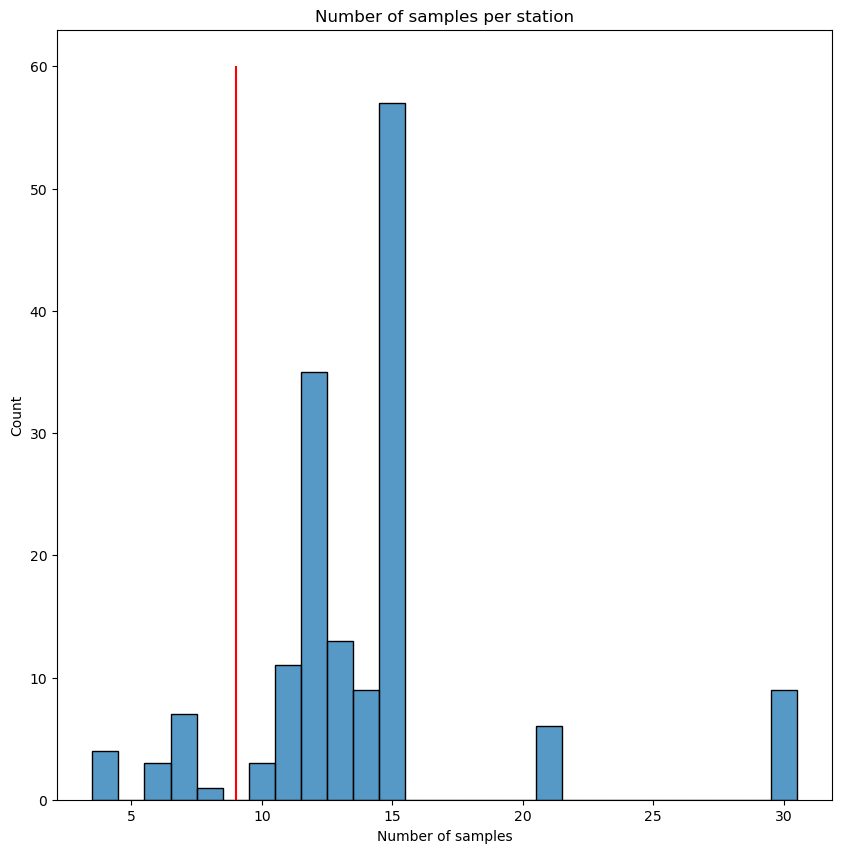

In [13]:

### undersampled locations
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
sns.histplot(phyto_abund_simplified[["id", "Date"]].drop_duplicates().groupby("id").count(), x = "Date", binwidth = 1, binrange = (3.5, 30.5), ax = ax)
ax.vlines(9, 0, 60, color = "red")
ax.set_title("Number of samples per station")
ax.set_xlabel("Number of samples")

In [15]:
# discarding stations having less than 9 samples
minimum_samples = 9
indices_enough_samples = phyto_abund_simplified[["id", "Date"]].drop_duplicates().groupby("id").count().query("Date > @minimum_samples").index

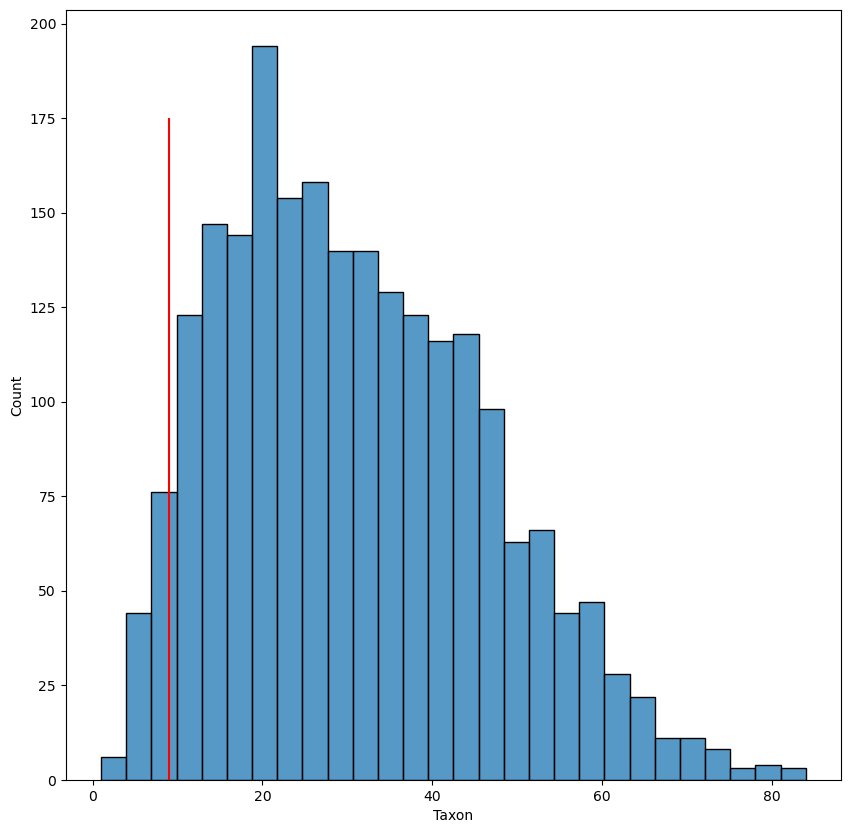

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
sns.histplot(phyto_abund_simplified.groupby(["Region", "id", "Date"]).count(), x = "Taxon", binwidth = 3, ax = ax)
ax.vlines(9, 0, 175, color = "red")

In [16]:
# removing samples having less than n taxa
minimunm_taxa = 5
relevant_samples = phyto_abund_simplified.loc[phyto_abund_simplified["id"].isin(indices_enough_samples), ["id", "Date", "Taxon"]].groupby(["id", "Date"]).count().query("Taxon > @minimunm_taxa").index

# Sampling campaign

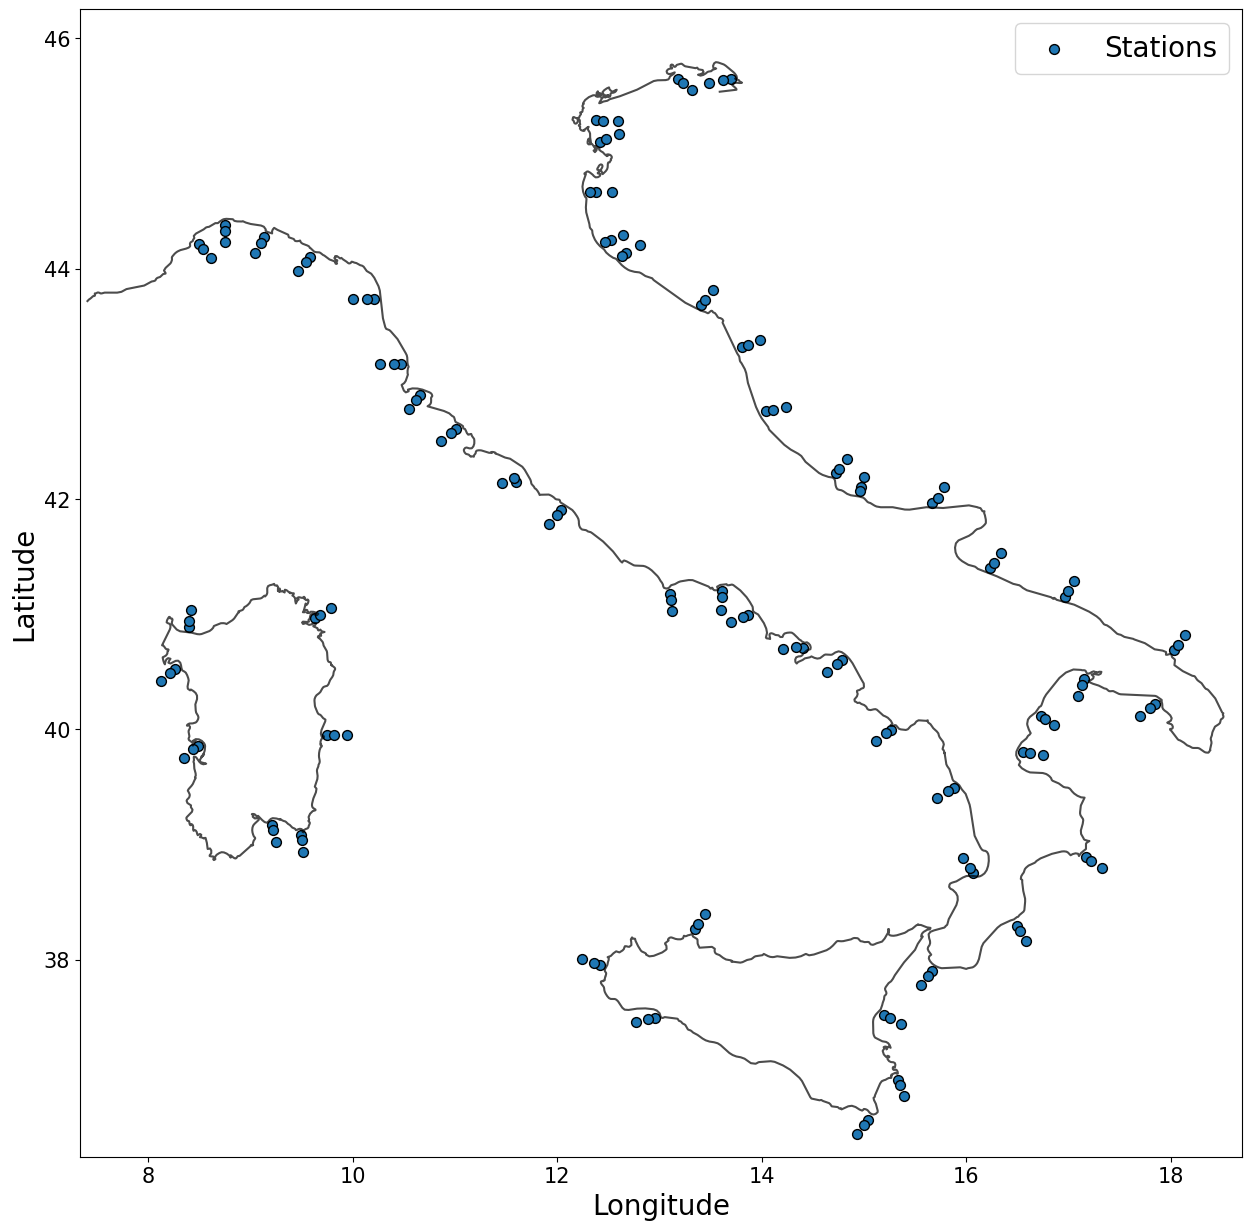

In [81]:
fig, ax = plt.subplots(1,1, figsize=(15,14.9))
plotting.plot_italian_coast(ax, (x_pen, x_sic, x_sard), (y_pen, y_sic, y_sard), alpha = 0.7)
ax.scatter(*phyto_abund_simplified[["Longitude", "Latitude"]].drop_duplicates().to_numpy().T, label = "Stations", edgecolor = "k", s = 50)
ax.legend(fontsize = 20)
ax.tick_params(labelsize=15)
ax.set_xlabel("Longitude", fontsize = 20)
ax.set_ylabel("Latitude", fontsize = 20)
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Stations.png", bbox_inches='tight')

In [159]:
data = phyto_abund_simplified[["Region", "Date", "id"]].groupby(by = ["Region", pd.Grouper(key = "Date", freq = "M")]).nunique( 
).divide(phyto_abund_simplified[["Region", "id"]].drop_duplicates().groupby("Region").count()
         ).pivot_table(index = "Region", columns= "Date", values = "id")
data[data.isna()] = 0

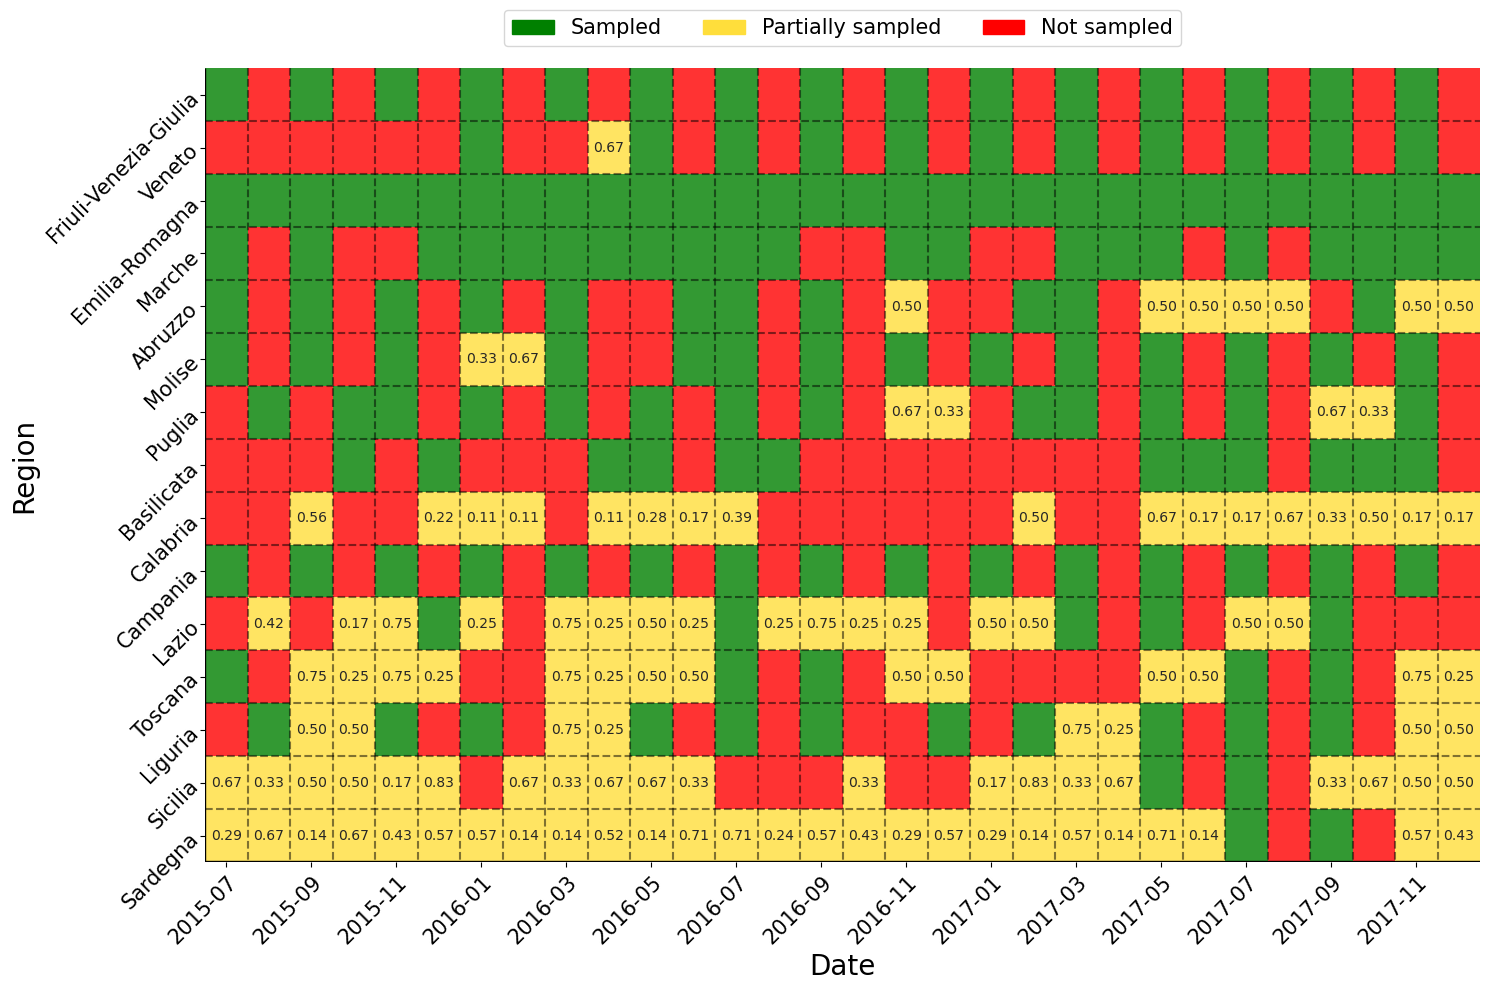

In [33]:
data = phyto_abund_simplified[["Region", "Date", "id"]].groupby(by = ["Region", pd.Grouper(key = "Date", freq = "M")]).nunique( 
).divide(phyto_abund_simplified[["Region", "id"]].drop_duplicates().groupby("Region").count()
         ).pivot_table(index = "Region", columns= "Date", values = "id")
data[data.isna()] = 0
data = data.loc[ordered_regions, :]
annot_label = np.where((data == 0) | (data == 1), "", np.char.mod('%.2f', data))
data[(data > 0) & (data < 1.0)] = 0.5
cmap = colors.ListedColormap(["red", "#FFDE3B", "green"])
fig, ax = plt.subplots(1,1, figsize=(15,10))
heatmap = sns.heatmap(data, ax = ax, 
            cbar = False, 
            cmap = cmap, 
            vmin = 0, 
            vmax = 1,
            alpha = 0.8,
            annot = annot_label, 
            fmt = "",
           )
ax.set_xlabel(ax.get_xlabel(), size = 20)
ax.set_ylabel(ax.get_ylabel(), size = 20)
ax.set_xticks([i + 0.5  for i in range(0, len(data.columns), 2)])
ax.set_xticklabels(data.columns[::2].strftime("%Y-%m"), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15); 
w = ax.get_xticks()
v = ax.get_yticks()
delta_xtick = w[1] - w[0] 
ax.vlines([i + delta_xtick / 4 for i in w], 0, 15, linestyles = "--", colors = "k", alpha = 0.5)
ax.vlines([i - delta_xtick / 4 for i in w[1:]], 0, 15, linestyles = "--", colors = "k", alpha = 0.5)
ax.vlines(0, 0, 15, linestyles = "-", colors = "black", linewidths = 1)
ax.hlines([(i + j) / 2 for i, j in zip(v, v[1:])], 0, 30, linestyles = "--", colors = "k", alpha = 0.5)
ax.hlines(14.98, 0, 30, linestyles = "-", colors = "black", linewidths = 1)
ax.set_yticklabels(ax.get_yticklabels(), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15)
sampled = mpatches.Patch(color=cmap(2), label='Sampled')
not_sampled = mpatches.Patch(color=cmap(0), label='Not sampled')
partial = mpatches.Patch(color=cmap(1), label='Partially sampled')
ax.legend(handles=[sampled, partial, not_sampled], bbox_to_anchor = (0, 1.0, 1, 0.101), loc= "center", ncols = 3, fontsize = 15)
plt.tight_layout()
plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Regions_date_sampling.png",bbox_inches='tight')

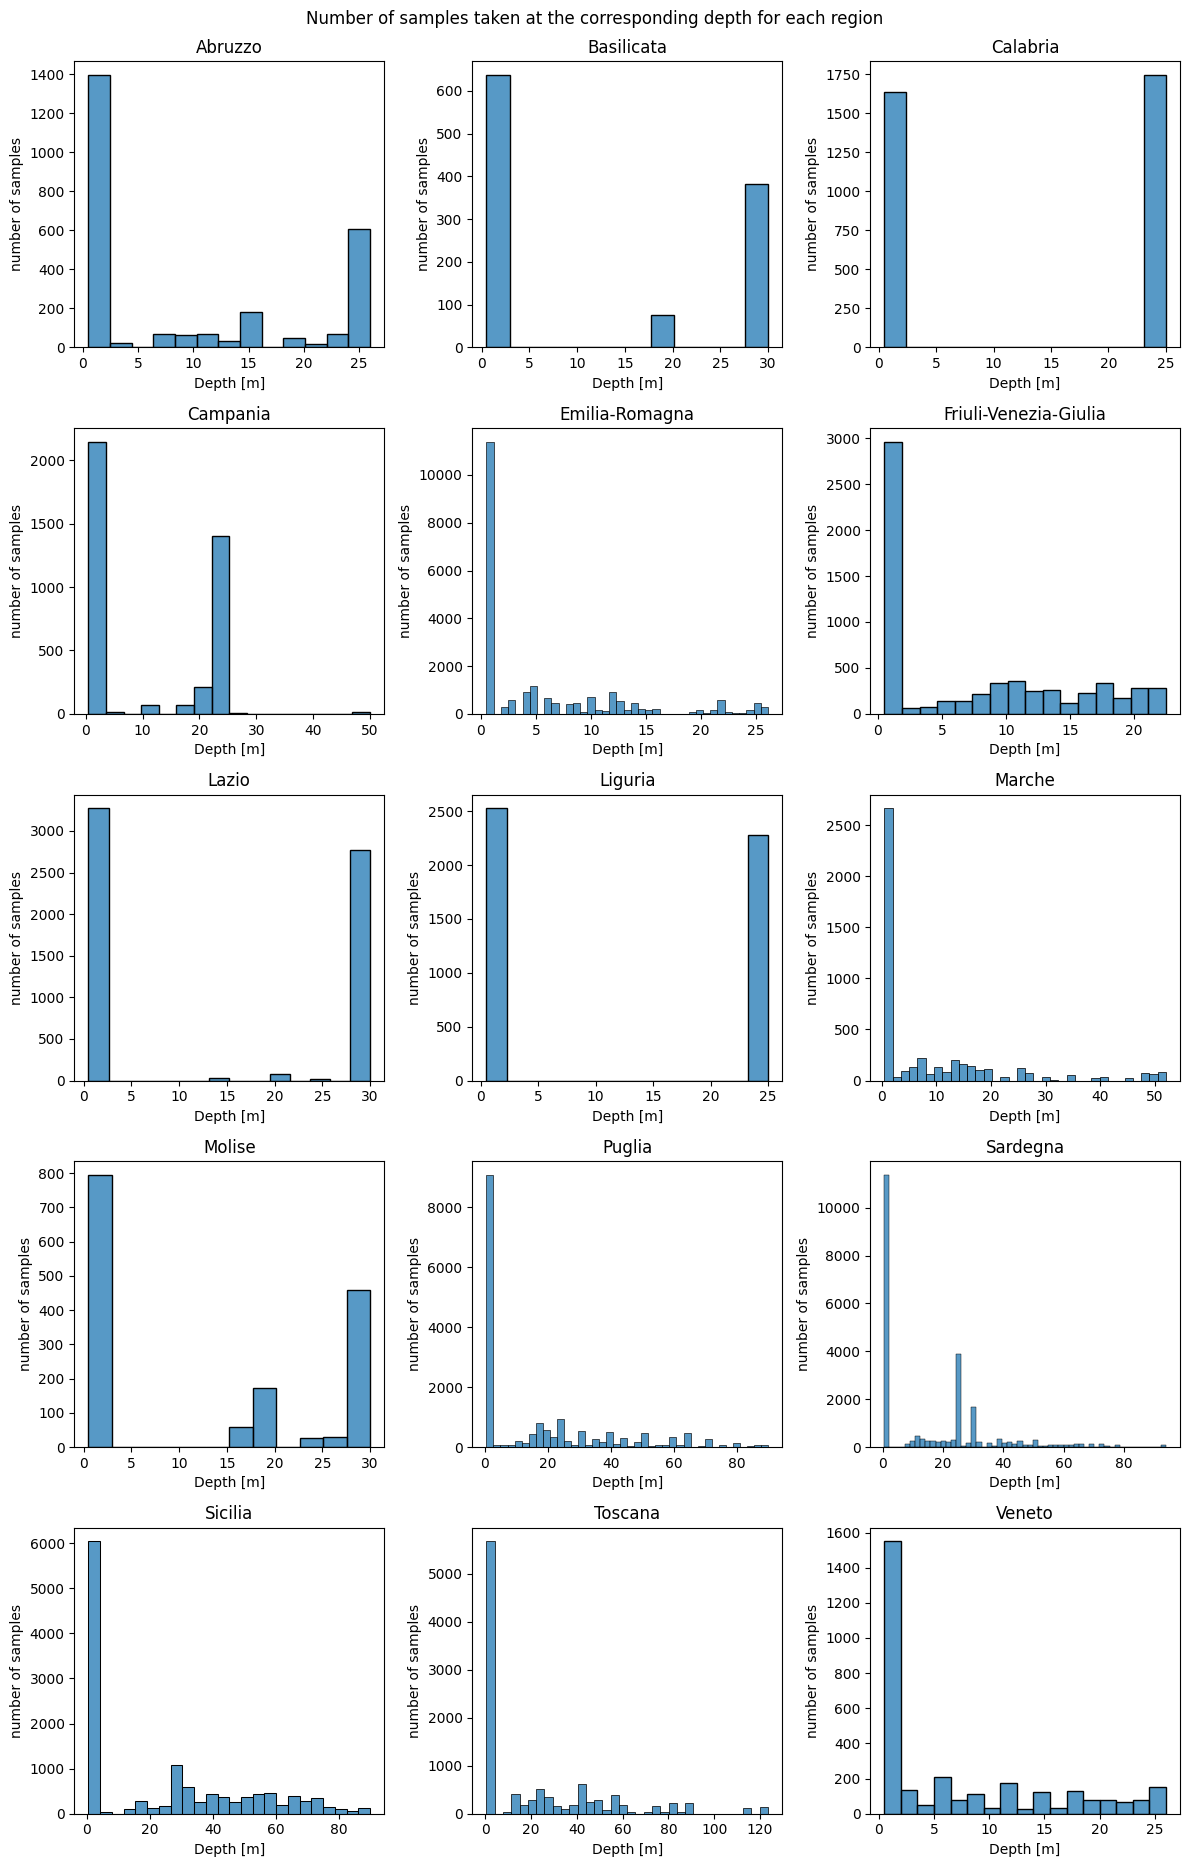

In [87]:
#df_most_abund_species = df_most_abund_species.query("Num_cell_l >= 3.0") 
figsize_dims = (12,19)
fig, axs = plt.subplots(5,3, figsize=figsize_dims);
axs = axs.flat

for ax, (name, df) in zip(axs, phyto_abundances[["Region", "id", "Sample_depth"]].groupby(by = "Region", observed=True)): 
    sns.histplot(data = df, x = "Sample_depth", ax = ax)
    ax.set_xlabel("Depth [m]");
    ax.set_ylabel("number of samples");
    ax.set_title(name);
plt.suptitle("Number of samples taken at the corresponding depth for each region")
plt.tight_layout(rect=[0,0,1,0.99])
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Depth_distribution.png", bbox_inches='tight')

In [85]:
phyto_abundances[["id", "Date", "Sample_depth"]].drop_duplicates()

,id,Date,Sample_depth
0,1_ABR_GU04,2015-07-23 00:00:00,0.5
20,1_ABR_GU04,2015-07-23 00:00:00,14.5
46,1_ABR_GU04,2015-09-17 00:00:00,0.5
71,1_ABR_GU04,2015-09-17 00:00:00,14.5
98,1_ABR_GU04,2015-11-04 00:00:00,0.5
...,...,...,...
123723,70720,2017-09-22 00:00:00,0.5
123744,70720,2017-09-22 00:00:00,25.0
123769,70720,2017-11-28 00:00:00,0.5
123786,70720,2017-11-28 00:00:00,12.0


How many stations reached the bottom? 

In [ ]:
df_deepest_depths = pd.merge(phyto_abundances[["id", "Sample_depth"]].sort_values("Sample_depth",ascending=False).drop_duplicates("id", keep="first"), right= df_lat_long_stations[["id", "Sea_depth"]], left_on="id", right_on="id")

In [ ]:
df_deepest_depths[df_deepest_depths.apply(lambda x: abs(x["Sample_depth"] - x["Sea_depth"]), axis = 1) <= 2.].count()

In [9]:
species_acc_curves = phyto_abund_simplified[["Region", "id", "Date", "Taxon"]].drop_duplicates(["Region", "Taxon"], keep = "first").groupby(["Region", "id", "Date"]).count().reset_index()
species_acc_curves["n_samples"] = 1
species_acc_curves[["new_species", "n_samples"]] = species_acc_curves.groupby(["Region", "id"]).agg({
    "Taxon" : "cumsum", "n_samples" : "cumsum"
})

### richness

## By class

In [58]:
abund_class = phyto_abund_simplified.groupby(["id", "Date", "Class"]).sum("Num_cell_l").reset_index()

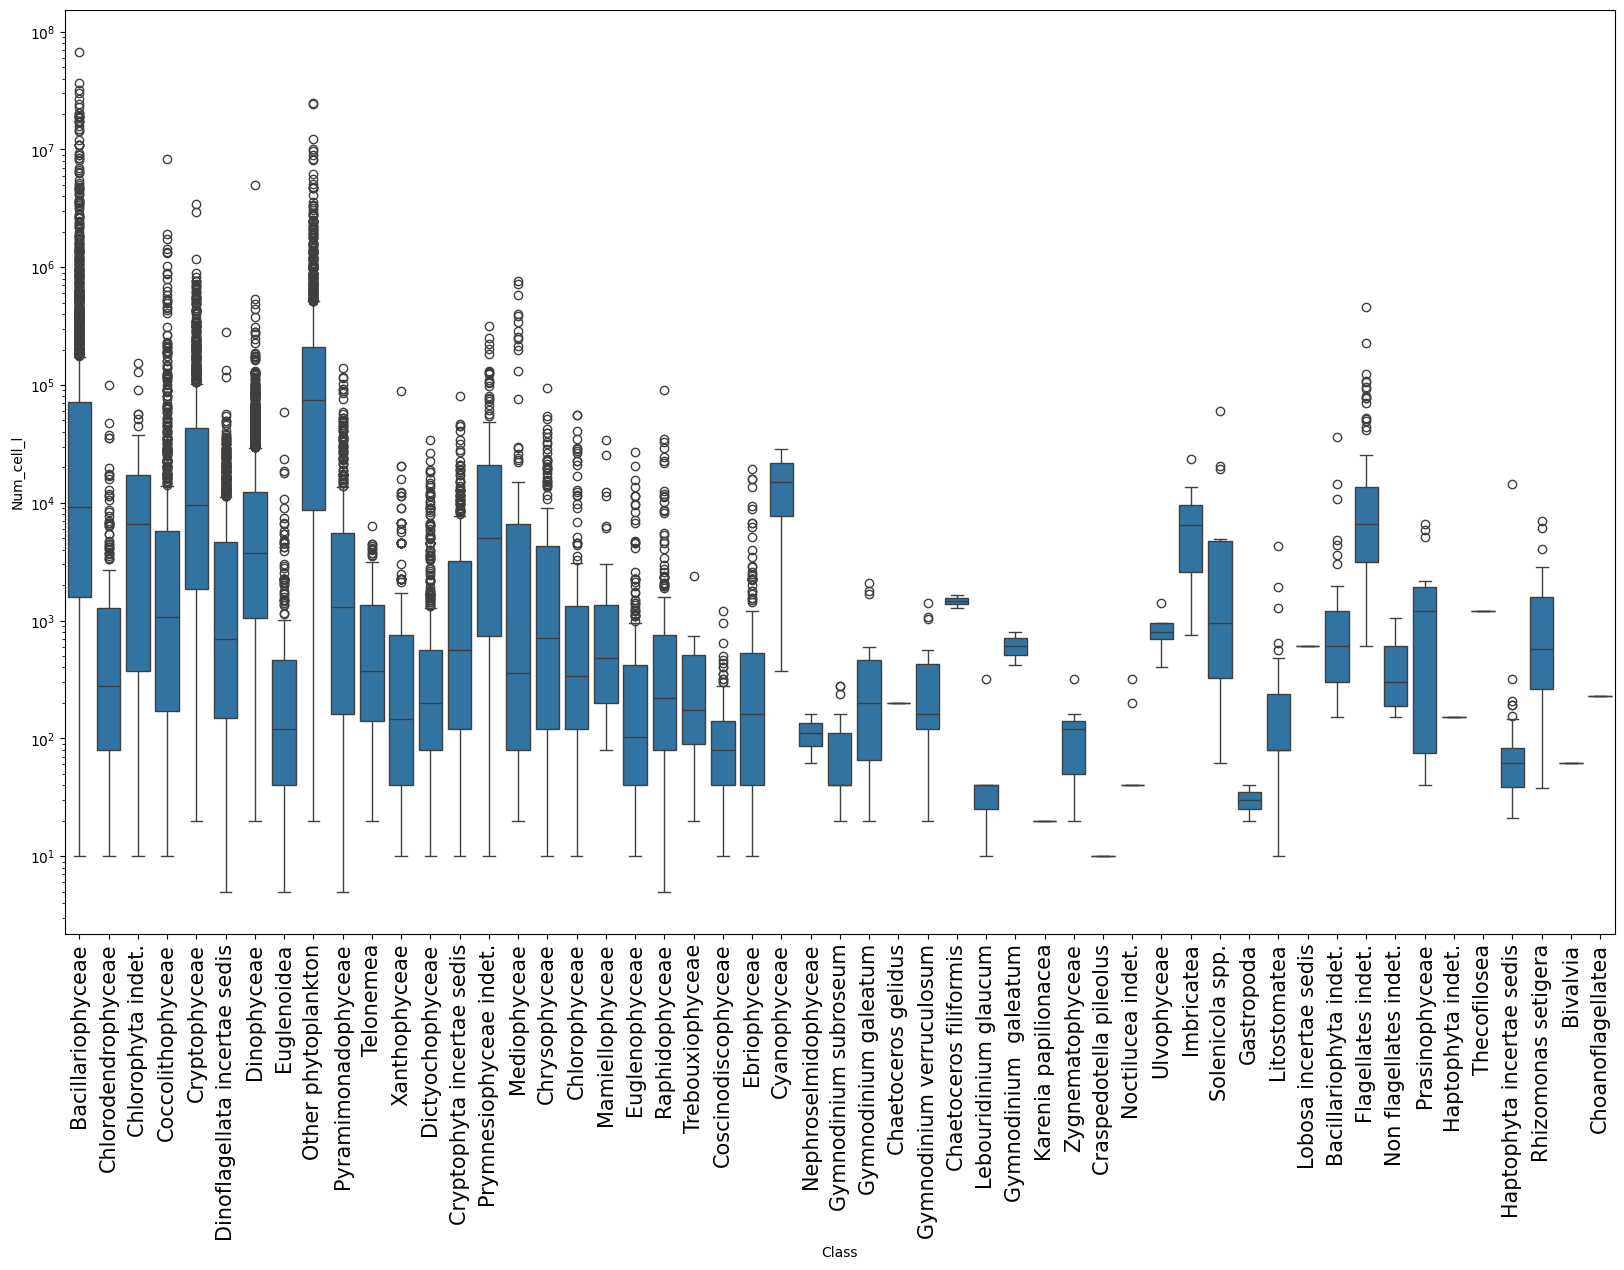

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
sns.boxplot(abund_class, x = "Class", y = "Num_cell_l", ax = ax)
ax.set_yscale("log")
xlabels = ax.get_xticklabels()
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(xlabels, rotation = 90, size = 15);

In [64]:
taxonomic_tree.loc[taxonomic_tree["Phylum"] != "Bacillariophyta", "Class"].unique()

array(['Chlorophyceae', 'Coccolithophyceae', 'Raphidophyceae',
       'Cryptophyceae', 'Mamiellophyceae', 'Dinophyceae', 'Chrysophyceae',
       'Dictyochophyceae', 'Trebouxiophyceae', 'Ebriophyceae', nan,
       'Prasinophyceae', 'Prymnesiophyceae', 'Chlorodendrophyceae',
       'Pyramimonadophyceae', 'Cryptophyta incertae sedis',
       'Dinoflagellata incertae sedis', 'Euglenoidea', 'Telonemea',
       'Euglenophyceae', 'Litostomatea', 'Coscinodiscophyceae',
       'Mediophyceae', 'Xanthophyceae', 'Noctilucea', 'Ulvophyceae',
       'Synurophyceae', 'Imbricatea', 'Lobosa incertae sedis',
       'Thecofilosea', 'Cyanophyceae', 'Kinetoplastea',
       'Zygnematophyceae', 'Gastropoda', 'Nephroselmidophyceae',
       'Haptophyta incertae sedis', 'Bivalvia', 'Choanoflagellatea'],
      dtype=object)

# Composition Analysis 

## overall considerations

In [12]:
species_abund = phyto_abund_simplified.query("Det_level == 'Species'")

In [13]:
#unique species
len(species_abund["Taxon"].unique())

551

In [14]:
species_freq = species_abund.loc[:, "Taxon"].value_counts().reset_index()
for fraction in [0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 0.95, 1]: 
    print(species_freq["count"].quantile(fraction))

2.0
3.0
3.0
6.0
10.0
53.0
343.5
1676.0


In [15]:
freq_rare = 2
rare_species = species_freq.loc[species_freq["count"] <= freq_rare, "Taxon"].unique()

In [16]:
common_species = species_freq[species_freq['count'] > species_freq['count'].quantile(0.95)]
print(f"number of species above the 95 quantile = {len(common_species)}")
common_species

number of species above the 95 quantile = 28


,Taxon,count
0,Leptocylindrus danicus,1676
1,Proboscia alata,1293
2,Cylindrotheca closterium,1114
3,Chaetoceros curvisetus,1098
4,Dictyocha fibula,1052
5,Thalassionema nitzschioides,1041
6,Dactyliosolen fragilissimus,990
7,Cerataulina pelagica,821
8,Prorocentrum micans,793
9,Guinardia striata,793


In [62]:
#in che regioni le specie più frequenti non sono state viste TODO
where_common_not_found = {}
for species in common_species:
    regions_no_obs = set(ordered_regions).difference(set(species_abund["Region"]))
    if regions_no_obs: 
        where_common_not_found[species] = list(regions_no_obs)
np.unique(list(itertools.chain(*where_common_not_found.values())), return_counts=True)

In [17]:
species_median_abund = species_abund[["Taxon", "Num_cell_l"]].groupby("Taxon").median().sort_values("Num_cell_l", ascending=False)["Num_cell_l"]
abund_species = species_median_abund[species_median_abund > species_median_abund.quantile(0.95)]
abund_species

Taxon
Chaetoceros delicatulus                 117652.000000
Dinobryon coalescens                     22678.000000
Chaetoceros compressus                   14476.458948
Cyclotella meneghiniana                  13606.500000
Cyclotella caspia                        11339.000000
Cyclotella glomerata                     11339.000000
Oltmannsiella lineata                     9071.000000
Paulinella ovalis                         8637.000000
Skeletonema mediterranea                  7401.000000
Chaetoceros neglectus                     5027.000000
leucocryptos                              4635.000000
Ollicola vangoorii                        4319.000000
Bacteriastrum jadranum                    3269.605214
Chaetoceros throndsenii                   3019.000000
Skeletonema tropicum                      2800.000000
Pseudo-nitzschia delicatissima            2512.000000
Bacteriastrum parallelum                  2268.000000
Navicula directa                          2268.000000
Leptocylindrus convexu

In [18]:
species_abund.loc[(species_abund["Num_cell_l"] < 100) & (species_abund["Region"] == "Sardegna"), 
                  "Num_cell_l"].unique()

array([20., 50., 40., 10., 80., 30., 60., 90., 70., 25.,  5., 15., 55.,
       35., 45.])

<Axes: xlabel='Num_cell_l', ylabel='Count'>

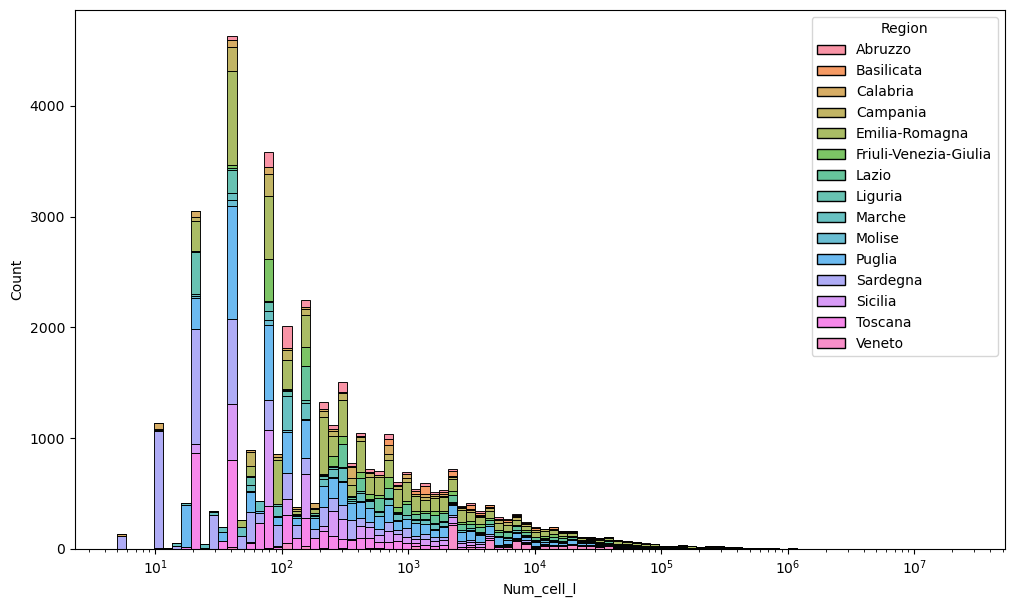

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.set_xscale("log")
sns.histplot(data = species_abund, 
             x = "Num_cell_l", 
             hue = "Region",
             multiple="stack",
             ax = ax
             )

In [28]:
df = phyto_abund_category.query("Det_level == 'Species'").loc[:, "Num_cell_l"]
for fraction in [0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 0.95, 1]: 
    print(df.quantile(fraction))

40.0
40.0
62.0
81.0
150.7964474
603.1857895
8545.000000000015
24119006.0


### frequency and rel. abund

In [72]:
relative_abund = phyto_abund_simplified[["Region", "id", "Date", "Num_cell_l"]].groupby(["Region", "id", "Date"]).sum()
relative_abund = phyto_abund_simplified[["Region", "id", "Date", "Taxon", "Num_cell_l"]].set_index(["Region", "id", "Date", "Taxon"]).div(relative_abund)

In [109]:
n_samples = phyto_abund_simplified.drop_duplicates(["id", "Date"]).groupby(["Region", "id"]).count()[["Date"]]
n_samples = n_samples.loc[n_samples["Date"] > 9, :]

In [114]:
taxa_freq = phyto_abund_simplified[["Region", "id", "Date", "Taxon"]].groupby(["Region", "id", "Taxon"]).count()
taxa_freq = taxa_freq.divide(n_samples)

#### based on freq. 

In [138]:
threshold = 0.1
taxa_low_freq = taxa_freq.loc[taxa_freq["Date"] <= threshold, :]

In [143]:
relative_abund.reset_index(["Date"]).loc[taxa_low_freq.index, :].query("Num_cell_l > 0.1")

Date  Num_cell_l
Region  id          Taxon                                            
Abruzzo 1_ABR_GU04  Leptocylindrus minimus     2017-03-31    0.214815
        1_ABR_GU06  Paralia sulcata            2015-11-30    0.173333
                    Scrippsiella spp.          2015-07-31    0.232143
        1_ABR_VA13  Chaetoceros messanensis    2017-03-31    0.105511
                    Dinophysis caudata         2017-08-31    0.115385
...                                                   ...         ...
Toscana SMR_CPI_WA3 Chaetoceros wighamii       2016-05-31    0.189110
                    Phaeocystis spp.           2016-07-31    0.132912
Veneto  50720       Cyclotella meneghiniana    2016-07-31    0.153193
        60530       Asterionellopsis glacialis 2016-11-30    0.114502
        70720       Asterionellopsis glacialis 2016-11-30    0.282609

[196 rows x 2 columns]

## Richness & Evenness

In [52]:
description = "viollnplots of richness  divided by season, no rarefaction"
@plotting.make_sim_directory(description)
def abund_and_composition_by_season(file_path, output_dir): 

    for (region, df_region) in phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby("Region"):

        ## abund per coastal distance
        abund_by_coast_dist = df_region.groupby(["id", "Date"]).agg({"Num_cell_l" : "count", "Season" : "first"}).reset_index()
        
        ## create figure
        fig, ax  = plt.subplots(figsize=(10, 13))

        ## boxplot 
        sns.violinplot(data = abund_by_coast_dist, x = "Season", y = "Num_cell_l", hue = "Season", ax = ax)
        ax.set_xlabel("Season", size = 15)
        ax.set_ylabel("Taxa richness", size = 15)
        ax.set_xticklabels(ax.get_xticklabels(), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15)
        ax.set_title(region, size = 20)

        plt.savefig(f"{file_path}/{output_dir}/{region}_richness.png", bbox_inches='tight')
        plt.close()
abund_and_composition_by_season(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots", "Richness_season")

/tmp/ipykernel_20569/3129409748.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15)
/tmp/ipykernel_20569/3129409748.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15)
/tmp/ipykernel_20569/3129409748.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15)
/tmp/ipykernel_20569/3129409748.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.

In [55]:
description = "boxplots of richness  divided by coastal distance, no rarefaction"
@plotting.make_sim_directory(description)
def abund_and_composition_by_season(file_path, output_dir): 

    for (region, df_region) in phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby("Region"):

        ## abund per coastal distance
        abund_by_coast_dist = df_region.groupby(["id", "Date"]).agg({"Num_cell_l" : "count", "Coast_dist" : "first"}).reset_index()
        
        ## create figure
        fig, ax  = plt.subplots(figsize=(10, 13))

        ## boxplot 
        sns.boxplot(data = abund_by_coast_dist, x = "Coast_dist", y = "Num_cell_l", hue = "Coast_dist", ax = ax)
        ax.set_xlabel("Coastal distance", size = 15)
        ax.set_ylabel("Taxa richness", size = 15)
        ax.set_xticklabels(ax.get_xticklabels(), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15)
        ax.set_title(region, size = 20)

        plt.savefig(f"{file_path}/{output_dir}/{region}_richness.png", bbox_inches='tight')
        plt.close()
abund_and_composition_by_season(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots", "Richness_coast_dist")

/tmp/ipykernel_20569/2533695383.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15)
/tmp/ipykernel_20569/2533695383.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15)
/tmp/ipykernel_20569/2533695383.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15)
/tmp/ipykernel_20569/2533695383.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.

In [225]:
def chi_square_dist(data): 
    """distance computed betweeen rows"""
    tot = np.sqrt(np.sum(data))
    N_i,N_j = data.shape
    q = np.zeros((N_i,N_j))
    row_sum = np.sum(data, axis = 1)
    col_sum = np.sum(data, axis = 0)
    for i in range(N_i): 
        for j in range(N_j): 
            q[i,j] = data[i,j] / ( row_sum[i]* np.sqrt(col_sum[j]))
    return euclidean_distances(q)

In [227]:
chi_square_dist(np.array([[0,1,1], [1,0,0], [0,4,8]]))

array([[0.        , 1.03816077, 0.09296223],
       [1.03816077, 0.        , 1.03518353],
       [0.09296223, 1.03518353, 0.        ]])

## heatmap on frequency

is turnover present?

In [59]:
_PATH_ = _HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Freq_regions/"

if not os.path.exists(_PATH_):
        os.mkdir(_PATH_)

for region in ordered_regions: 
    fig, ax = plt.subplots(1,1, figsize=(20, 11))
    freq_species = phyto_abund_simplified.query("Region == @region")[["Season", "Taxon", "id"]].groupby(["Season", "Taxon"]).count()
    freq_samples = phyto_abund_simplified.query("Region == @region").drop_duplicates(["Date", "id"])[["Season", "id"]].groupby("Season").count()
    freq_species = freq_species.div(freq_samples)
    sns.heatmap(freq_species.reset_index().pivot(index="Season", columns="Taxon", values="id").fillna(0), ax = ax)
    plt.tight_layout()
    plt.savefig(_PATH_ + f"/freq_{region}.png")
    plt.close()


## heatmap on abund

In [73]:
_PATH_ = _HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Abund_regions/"

if not os.path.exists(_PATH_):
        os.mkdir(_PATH_)
    
for region in ordered_regions: 
    fig, ax = plt.subplots(1,1, figsize=(20, 11))
    abund_species = phyto_abund_simplified.query("Region == @region")[["Season", "Taxon", "Num_cell_l"]].groupby(["Season", "Taxon"]).sum()
    abund_samples = phyto_abund_simplified.query("Region == @region")[["Season", "Num_cell_l"]].groupby("Season").sum()
    abund_species = abund_species.div(abund_samples)
    sns.heatmap(abund_species.reset_index().pivot(index="Season", columns="Taxon", values="Num_cell_l").fillna(0), ax = ax, norm = LogNorm(), cmap="jet")
    plt.tight_layout()
    plt.savefig(_PATH_ + f"/abund_{region}.png")
    plt.close()


## relevant taxa

In [14]:
relevant_taxa = []
with open(_HOME_ + "/ISPRA_20152017_Analysis/selected_species.txt", "r") as in_file: 
    for line in in_file: 
        relevant_taxa.append(line.strip())

In [15]:
slice_important_species = phyto_abund_simplified.query("Taxon in @relevant_taxa").copy()
slice_important_species["id"] = pd.Categorical(slice_important_species["id"], ordered = True, categories = ordered_id)

In [21]:
slice_important_species.groupby("Taxon").agg(
        {"Region" : "nunique"
         }).sort_values(ascending=False, by="Region").to_csv(_HOME_ + "/ISPRA_20152017_Analysis/important_species_n_regions.csv")

In [30]:
(slice_important_species.groupby("Taxon").agg(
        {"Region" : "nunique"
         }) >=12 ).sum()

Region    74
dtype: int64

In [55]:
index = slice_important_species.groupby("Taxon").agg(
        {"Region" : "nunique", 
         "Season" : "nunique",
         }
    ).query("Region <= 5").index
slice_important_species.query("Taxon in @index")[["Region","Taxon"]].drop_duplicates().sort_values("Taxon")

,Region,Taxon
56706,Toscana,Amphidinium carterae
39669,Sardegna,Amphidinium carterae
2085,Calabria,Amphidinium carterae
6618,Emilia-Romagna,Amphidoma spp.
3753,Campania,Anoplosolenia brasiliensis
...,...,...
6757,Emilia-Romagna,Pyramimonadophyceae
24199,Liguria,Rhizosolenia hebetata
55778,Toscana,Rhizosolenia hebetata
38589,Sardegna,Rhizosolenia hebetata


In [47]:
display(slice_important_species.groupby("Taxon").agg(
    {"Region" : "nunique", 
        "Season" : "nunique",
        }
).query("Season != 4"))

,Region,Season
Taxon,,
Amphidoma spp.,1,3
Calyptrosphaera spp.,4,3
Chaetoceros didymus,12,3
Chaetoceros rostratus,5,3
Cyclotella caspia,1,3
Diploneis crabro,2,3
Gymnodinium simplex,1,2
Hermesinum adriaticum,7,3
Micromonas spp.,3,3


In [29]:
slice_important_species.groupby("Region", observed = True).agg(
    {"Taxon" : "nunique"}
)

,Taxon
Region,
Friuli-Venezia-Giulia,115
Veneto,87
Emilia-Romagna,117
Marche,95
Abruzzo,57
Molise,76
Puglia,128
Basilicata,51
Calabria,106


In [56]:
index = slice_important_species.groupby("Taxon").agg(
    {"Region" : "nunique", 
        "Season" : "nunique",
        }
).query("Season != 4").index
slice_important_species.query("Taxon in @index")[["Season","Taxon"]].drop_duplicates().sort_values("Taxon")

,Season,Taxon
14624,Autumn,Amphidoma spp.
11746,Winter,Amphidoma spp.
6618,Spring,Amphidoma spp.
2086,Autumn,Calyptrosphaera spp.
2314,Spring,Calyptrosphaera spp.
2926,Summer,Calyptrosphaera spp.
597,Winter,Chaetoceros didymus
4172,Summer,Chaetoceros didymus
4198,Autumn,Chaetoceros didymus
12978,Winter,Chaetoceros rostratus


In [44]:
jaccard_sim = (1 - pairwise_distances(slice_important_species.pivot_table(index = "id", columns = "Taxon", values = "Num_cell_l", fill_value=0).to_numpy(), metric = "jaccard"))

/home/alberto/miniconda3/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


<Axes: >

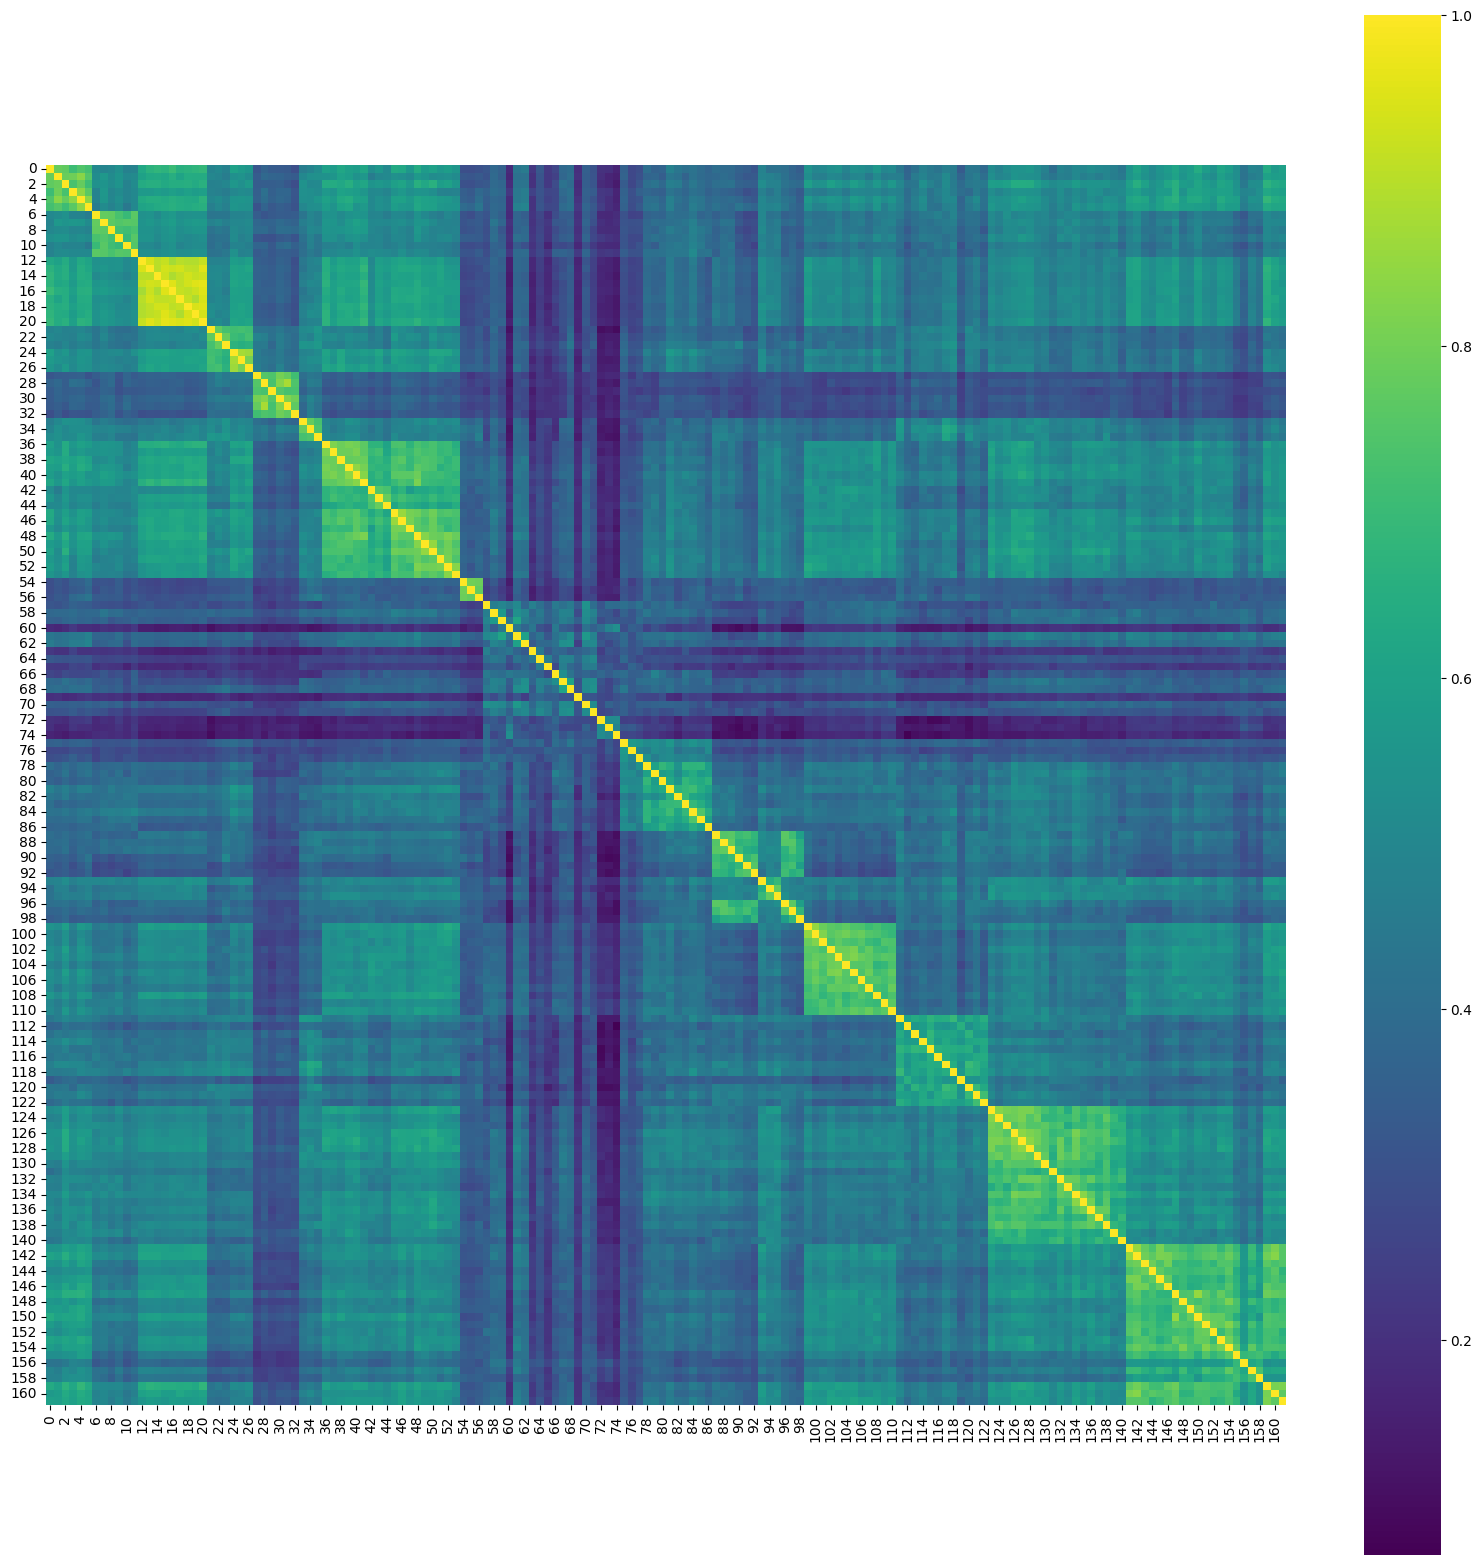

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.heatmap(jaccard_sim, ax = ax, cmap = "viridis", square = True)

## rare taxa

In [25]:
indval_regions = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/IndVal_per_region.xlsx", sheet_name=None)

In [73]:
all_indvals = pd.concat(indval_regions.values(), axis = 0)
rare_taxa = all_indvals.query("pval <0.05").groupby("Taxa").agg({"max_val" : "max"}).query("max_val <= 0.25").index

In [75]:
slice_rare_taxa = phyto_abund_simplified.query("Taxon in @rare_taxa").copy()

In [76]:
slice_rare_taxa.groupby("Taxon").agg(
        {"Region" : "nunique", 
         "Season" : "nunique",
         }
    ).sort_values("Region", ascending=False)

,Region,Season
Taxon,,
Ceratium tripos,14,4
Ceratium trichoceros,14,4
Gonyaulax spp.,14,4
Dinophysis caudata,14,4
Chaetoceros brevis,13,4
...,...,...
Pseudo-nitzschia delicatissima.,1,1
Micracanthodinium setiferum,1,3
Pseudo-nitzschia australis,1,1


In [77]:
phyto_abund_simplified.loc[phyto_abund_simplified["Taxon"].str.contains("Pseudo-nitzschia delicatissima"), "Taxon"].unique()

array(['Pseudo-nitzschia delicatissima',
       'Pseudo-nitzschia delicatissima.'], dtype=object)

## IndVal per regione

indval computed by vegan

In [15]:
indval_regions = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/IndVal_per_region.xlsx", sheet_name=None)

In [20]:
if not os.path.exists(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Indval_regions"):
        os.mkdir(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Indval_regions")

In [44]:
description = "Indval plots of regions, using only relevant taxa"

@plotting.make_sim_directory(description)
def plot_indval_regions(file_path, output_dir):
    for (region, df_indval) in indval_regions.items():
        fig, ax = plt.subplots(1,1, figsize=(20, 11))
        df_indval = df_indval.query("Taxa in @relevant_taxa").drop(["max_val", "pval"], axis = 1)
        idx = df_indval.melt(id_vars = "Taxa", var_name = "Season", value_name = "IndVal").groupby("Taxa")["IndVal"].idxmax()
        taxa = df_indval.melt(id_vars = "Taxa", var_name = "Season", value_name = "IndVal").loc[idx].sort_values(["Season", "IndVal"], ascending=[True, False])["Taxa"]
        img = sns.heatmap(df_indval.set_index("Taxa").loc[taxa, :], cmap = "viridis",
            ax = ax, 
            cbar = False
                    )
        ax.set_ylabel("")
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), size = 15)
        ax.set_yticks(ax.get_yticks())
        ax.set_yticklabels(ax.get_yticklabels(), size = 13)
        cbar = plt.colorbar(img.get_children()[0], ax = ax)
        cbar.set_label("IndVal", size = 15)
        cbar.ax.tick_params(labelsize=15)
        plt.tight_layout()
        plt.savefig(f"{file_path}/{output_dir}/indval_{region}.png", bbox_inches='tight')
        plt.close()
plot_indval_regions(_HOME_ + "/ISPRA_20152017_Analysis/Plots", "Indval_regions")

In [38]:
len(ax.get_yticklabels())

59

In [40]:
len(ax.get_yticks())

59

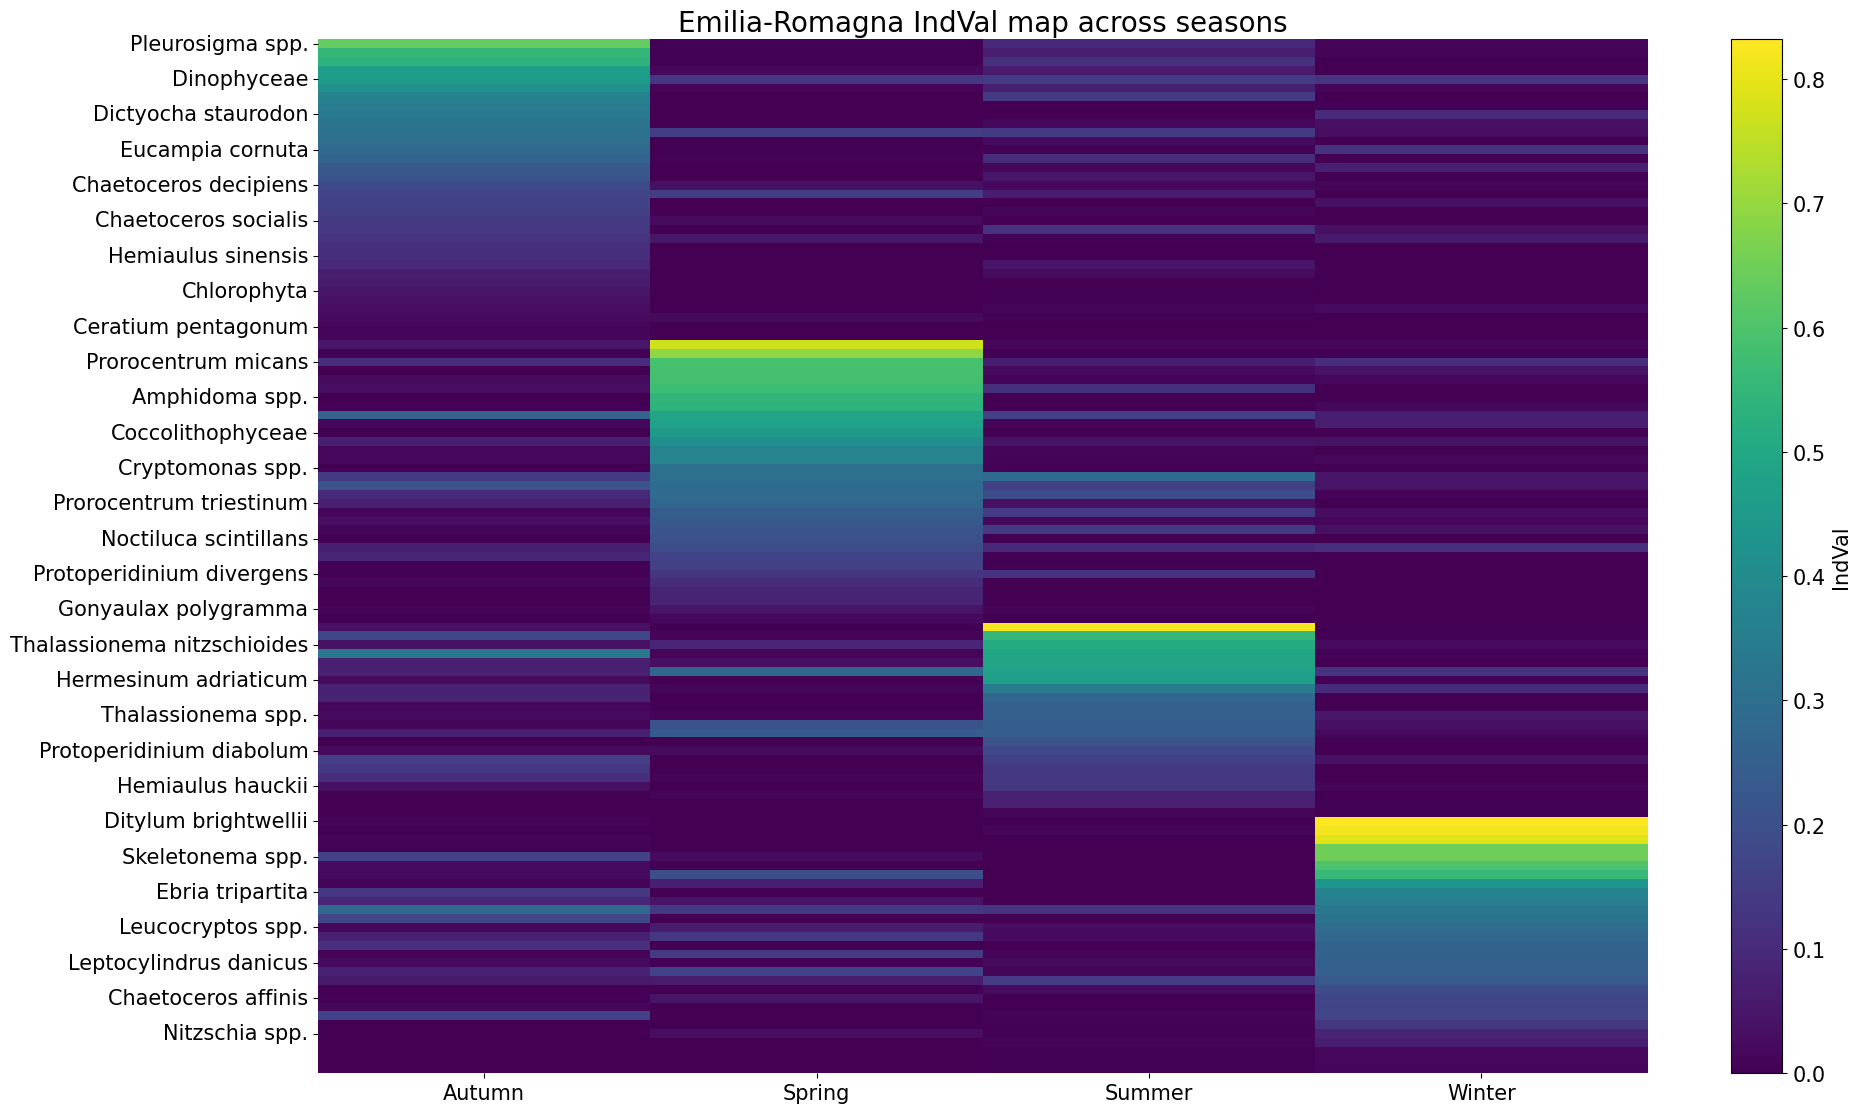

In [17]:
fig, ax = plt.subplots(1,1, figsize=(20, 11))
df_indval = indval_regions["Emilia-Romagna"]
df_indval = df_indval.query("Taxa in @relevant_taxa").drop(["max_val", "pval"], axis = 1)
idx = df_indval.melt(id_vars = "Taxa", var_name = "Season", value_name = "IndVal").groupby("Taxa")["IndVal"].idxmax()
taxa = df_indval.melt(id_vars = "Taxa", var_name = "Season", value_name = "IndVal").loc[idx].sort_values(["Season", "IndVal"], ascending=[True, False])["Taxa"]
img = sns.heatmap(df_indval.set_index("Taxa").loc[taxa, :], cmap = "viridis",
    ax = ax, 
    cbar = False
            )
ax.set_ylabel("")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), size = 15)
ax.set_yticks(ax.get_yticks()[:-1:2])
ax.set_yticklabels(ax.get_yticklabels(), size = 15)
cbar = plt.colorbar(img.get_children()[0], ax = ax)
cbar.set_label("IndVal", size = 15)
cbar.ax.tick_params(labelsize=15)
plt.tight_layout()
plt.title("Emilia-Romagna IndVal map across seasons", size = 20)
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Plots/indval_EMR.png",bbox_inches='tight')
#plt.savefig(f"{file_path}/{output_dir}/indval_{region}.png")

/tmp/ipykernel_5226/1006983199.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(labels = axs[2].get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);


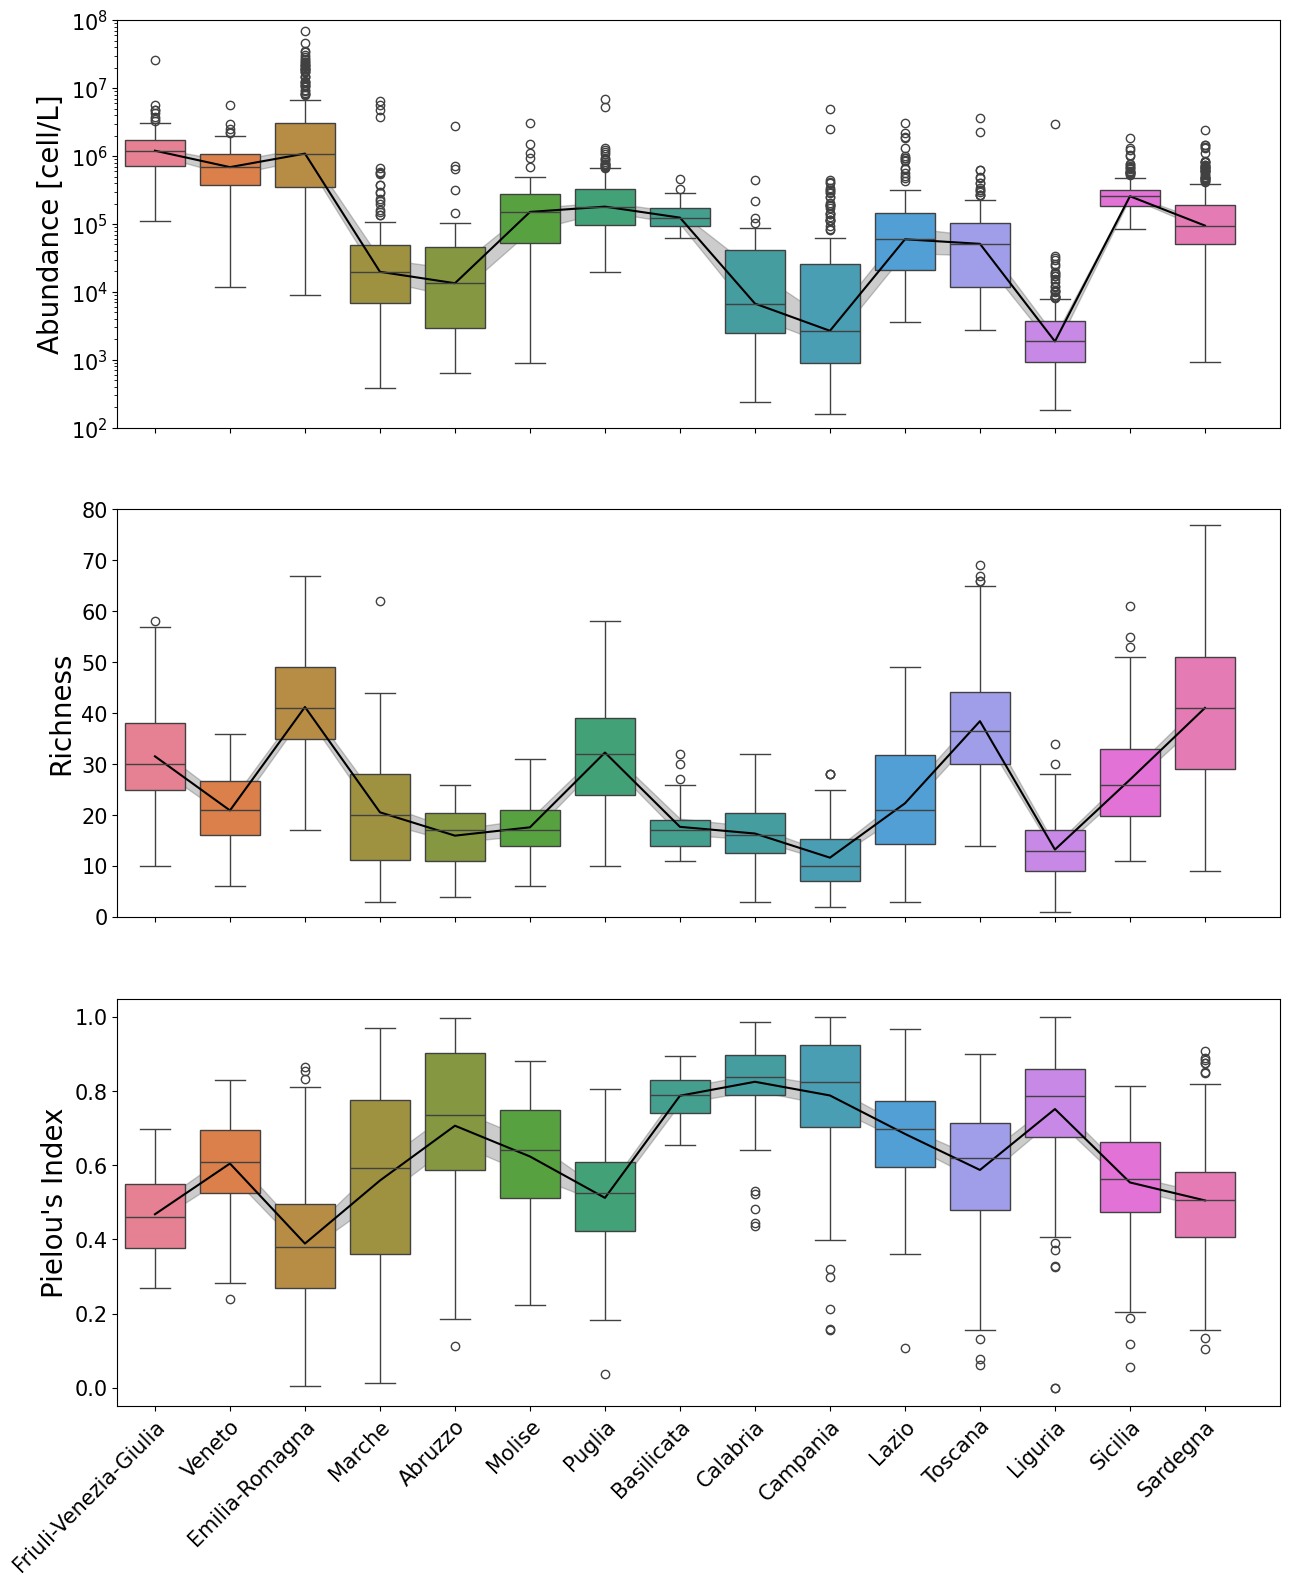

In [24]:
fig, axs = plt.subplots(3,1, figsize=(15, 18), sharex=True)
axs = axs.flat
ax.hlines(10**6, -0.5, 15, colors="k", linestyles="dashed")
sns.boxplot(
    phyto_abund_simplified.groupby(["Region", "id", "Date"], observed = True).sum("Num_cell_l").loc[ordered_regions,:].reset_index(),
    x = "Region", 
    y = "Num_cell_l",
    hue = "Region",
    ax = axs[0]
)
sns.lineplot(
    phyto_abund_simplified.groupby(["Region", "id", "Date"], observed = True).sum("Num_cell_l").loc[ordered_regions,:].reset_index(),
    x = "Region", 
    y = "Num_cell_l",
    estimator="median",
    color = "black",
    ax = axs[0]

)
axs[0].set_yscale("log")
axs[0].set_ylabel("Abundance [cell/L]", fontsize = 20)
axs[0].set_yticks(axs[0].get_yticks())
axs[0].set_yticklabels(labels = axs[0].get_yticklabels(), fontsize = 15);
axs[0].set_ylim(10**2, 10**8)

sns.boxplot(
    phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["Region", "id", "Date"], observed = True).count().loc[ordered_regions,:].reset_index(),
    x = "Region", 
    y = "Taxon",
    hue = "Region",
    ax = axs[1]
)
sns.lineplot(
    phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["Region", "id", "Date"], observed = True).count().loc[ordered_regions,:].reset_index(),
    x = "Region", 
    y = "Taxon",
    color = "k",
    ax = axs[1]

)
axs[1].set_ylabel("Richness", fontsize = 20)
axs[1].set_yticks(axs[1].get_yticks())
axs[1].set_yticklabels(labels = axs[1].get_yticklabels(), fontsize = 15);
axs[1].set_ylim(0,80)
sns.boxplot(
    phyto_abund_simplified.query("Taxon != 'Other phytoplankton'")[["Region", "id", "Date", "Num_cell_l"]].groupby(["Region", "id", "Date"], observed = True).agg(Pielou_evenness).loc[ordered_regions,:].reset_index(),
    x = "Region", 
    y = "Num_cell_l",
    hue = "Region",
    ax = axs[2]
)
sns.lineplot(
    phyto_abund_simplified.query("Taxon != 'Other phytoplankton'")[["Region", "id", "Date", "Num_cell_l"]].groupby(["Region", "id", "Date"], observed = True).agg(Pielou_evenness).loc[ordered_regions,:].reset_index(),
    x = "Region", 
    y = "Num_cell_l",
    color = "k",
    ax = axs[2]

)

axs[2].set_yticks(axs[2].get_yticks())
axs[2].set_yticklabels(labels = axs[2].get_yticklabels(), fontsize = 15);
axs[2].set_ylabel("Pielou's Index", fontsize = 20)
axs[2].set_ylim(-0.05, 1.05)

axs[2].set_xlim(-0.5, 15)
axs[2].set_xticklabels(labels = axs[2].get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
axs[2].set_xlabel("")
axs[2].set_yticklabels(labels = axs[2].get_yticklabels(), fontsize = 15);

plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Plots/boxplot_abund_rich_even_by_region.png",bbox_inches='tight')